# Train a U-Net Model from scratch

## Load data

In [1]:
%matplotlib inline

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, models

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

import skimage.transform
import re

import napari

# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)

2.2.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


C:\Users\Lab513\AppData\Roaming\Python\Python38\site-packages\napari\_qt\__init__.py:38: UserWarning: napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


In [2]:
class ImageMaskGenerator(Sequence):
    """
    Generates images and masks for performing data augmentation in Keras.
    We inherit from Sequence (instead of directly using the keras ImageDataGenerator)
    since we want to perform augmentation on both the input image AND the mask 
    (target). This mechanism needs to be implemented in this class. This class
    also allows to implement new augmentation transforms that are not implemented
    in the core Keras class (illumination, etc.).
    See : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    and https://stackoverflow.com/questions/56758592/how-to-customize-imagedatagenerator-in-order-to-modify-the-target-variable-value
    for more details.
    """

    def __init__(self, X_set, Y_set=None, # input images and masks
                 batch_size: int=32, dim: tuple=(512, 512),
                 n_channels_ims: int=1, n_channels_masks: int=1, # informations 
                 shuffle: bool=True, normalize_ims=True, normalize_masks=False, reshape=False, crop=None,# preprocessing params
                 **kwargs): # data augmentation params
        """
        X_set (list, array or str): pointer to the images (Bright-Field). If str
        the string is assumed to be pointing at some directory.
        Y_set (list; array or str): pointer to the masks (target). If str
        the string is assumed to be pointing at some directory.
        batch_size (int): size of the batch
        dim (tuple): dimension of the images
        n_channels_ims (int) : number of channels of the images (1 for TIF)
        shuffle (bool): Shuffle the dataset between each training epoch
        crop (tuple): Target dim of one image after cropping
        normalize (bool): normalize the images and masks in the beginning
        reshape (bool): reshape the images and masks to (dim, dim, n_channels_ims)
        histogram_equalization (bool): perform histogram equalization to improve
        rendering using opencv
        horiz_flip_percent ()
        vert_flip_percent
        """
        # super().__init__(n, batch_size, shuffle, seed)
        self.dim = dim
        self.im_size = dim
        self.batch_size = batch_size
        self.n_channels_ims = n_channels_ims
        self.n_channels_masks = n_channels_masks
        
        # build the X_set in an array. If X_set is a directory containing images
        # then self.X_set doesn't contains the images but the file names, but it
        # is transparent for the user.
        if type(X_set) == list:
            self.from_directory_X = False
            self.X_set = np.array(X_set)
        elif type(X_set) == np.array:
            self.from_directory_X = False
            self.X_set = X_set
        elif type(X_set) == str: # assuming a path
            self.from_directory_X = True
            self.X_dir = X_set # path to the images dir
#             if self.n_channels_ims == 1:
#                 self.X_set = np.array(sorted(os.listdir(X_set))) # sorted guarantees the order
#             else: # n_channels_ims > 1 : several channels per image
            self.X_set = []
            for k in range(0, len(os.listdir(X_set)), self.n_channels_ims):
                self.X_set.append(np.array(os.listdir(X_set)[k:k+self.n_channels_ims]))
            self.X_set = np.array(self.X_set)
        else:
            raise TypeError("X_set should be list, array or path")
        
        # build the Y_set in an array
        if type(Y_set) == list:
            self.from_directory_Y = False
            self.Y_set = np.array(Y_set)
        elif type(Y_set) == np.array:
            self.from_directory_Y = False
            self.Y_set = Y_set
        elif type(Y_set) == str: # assuming a path
            self.from_directory_Y = True
            self.Y_dir = Y_set # path to the masks dir
            self.Y_set = []
            for k in range(0, len(os.listdir(Y_set)), self.n_channels_masks):
                self.Y_set.append(np.array(os.listdir(Y_set)[k:k+self.n_channels_masks]))
            self.Y_set = np.array(self.Y_set)
        else:
            raise TypeError("Y_set should be list, array or path")

        # Check if there are the same number of images in X (images) and Y (masks)
        assert self.X_set.shape[0] != 0 and self.Y_set.shape[0] != 0, print(f"Directory '{X_set}' is empty!")
        assert self.X_set.shape[0] == self.Y_set.shape[0], print(f"{self.X_set.shape[0]} images != {self.Y_set.shape[0]} masks")

        self.shuffle = shuffle

        # Preprocessing parameters
        self.normalize_ims = normalize_ims
        self.normalize_masks = normalize_masks
        self.reshape = reshape
        self.crop = crop

        # The Keras generator that will be used to perform data augmentation 
        self.generator = ImageDataGenerator(**kwargs)

        # Initialize the indices (shuffle if asked)
        self.on_epoch_end()

    def __len__(self) -> int:
        """
        Number of batches per epoch : we evenly split the train set into samples
        of size batch_size.
        """
        return int(np.floor(self.X_set.shape[0] / self.batch_size))
        
    def __getitem__(self, index: int):
        """
        Generate one batch of data.
        """
        if index >= self.__len__():
            raise IndexError
        
        # Generate indices corresponding to the images in the batch
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate the batch
        X, Y = self.__data_generation(indices)
        return X, Y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch. self.indexes is used to retrieve the
        samples and organize them into batches.
        If shuffle : randomizes the order of the samples in order to give 
        different training batches at each epoch.
        """
        self.indexes = np.arange(self.X_set.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs: [int]):
        """
        Generates data containing batch_size samples. This is where we load the
        images if they are in a directory, and apply transformations to them.
        """ 
        # Load data (from directory or from X_set depending on the given data)
        if self.from_directory_X:
            batch_X = []
            for im in list_IDs:
                channels = []
                for k in range(self.n_channels_ims):
                    channels.append(np.expand_dims(imageio.imread(f"{self.X_dir}/{self.X_set[im, k]}"), axis=-1)) # add channel axis
                batch_X.append(np.concatenate(channels, axis=-1))
            batch_X = np.array(batch_X)
        else:
            batch_X = self.X_set[list_IDs]

        if self.from_directory_Y:
            batch_Y = []
            for im in list_IDs:
                channels = []
                for k in range(self.n_channels_masks):
                    channels.append(np.expand_dims(imageio.imread(f"{self.Y_dir}/{self.Y_set[im, k]}"), axis=-1)) # add channel axis
                batch_Y.append(np.concatenate(channels, axis=-1))
            batch_Y = np.array(batch_Y) 
        else:
            batch_Y = self.Y_set[list_IDs]

        # Preprocessing
        if self.crop is not None:
            batch_X = self.perf_crop(batch_X)
            batch_Y = self.perf_crop(batch_Y)

        if self.reshape:
            batch_X = self.perf_reshape(batch_X, is_images=True)
            batch_Y = self.perf_reshape(batch_Y, is_images=False)

        if self.normalize_ims:
            batch_X = self.perf_normalize(batch_X)
#             batch_X = self.perf_standardize(batch_X)
        if self.normalize_masks:
            batch_Y = self.perf_normalize(batch_Y)
#             batch_Y = self.perf_standardize(batch_Y)

#         if self.n_channels_ims == 3:
#             batch_X = np.concatenate([batch_X, batch_X, batch_X], axis=-1)

        # Perform the SAME transformation on the image and on the mask
        for i, (img, mask) in enumerate(zip(batch_X, batch_Y)):
            transform_params = self.generator.get_random_transform(img.shape)
            batch_X[i] = self.generator.apply_transform(img, transform_params)
            batch_Y[i] = self.generator.apply_transform(mask, transform_params)
            
#         assert (batch_X.min(axis=(0, 1, 2, 3)) == 0 and batch_Y.max(axis=(0, 1, 2, 3)) == 1)
            
        return batch_X, batch_Y        

    # Preprocessing functions
    def perf_crop(self, images):
        crop_X = int((images.shape[1] - self.crop[0]) // 2)
        crop_Y = int((images.shape[2] - self.crop[1]) // 2)
        assert (crop_X >= 0 and crop_Y >= 0), print(f"Target size after cropping {self.crop} should be lower than the initial shape {(images.shape[1], images.shape[2])}.")
        new_batch = np.empty((self.batch_size, *self.crop, images.shape[3]))
        for i, img in enumerate(images):
            if crop_X != 0 and crop_Y != 0:
                new_batch[i] = img[crop_X:-crop_X, crop_Y:-crop_Y]
            elif crop_X != 0:
                new_batch[i] = img[crop_X:-crop_X, :]
            elif crop_Y != 0:
                new_batch[i] = img[:, crop_Y:-crop_Y]
            else:
                new_batch[i] = img
        return new_batch

    def perf_reshape(self, images, is_images=True):
        """
        images (np.array): batch of images of shape (batch_size, n_rows, n_cols, n_chans)
        is_images (bool): is it a batch of images (True) or masks (False)
        """
        if is_images:  # batch of images
            new_batch = np.empty((self.batch_size, *self.im_size, self.n_channels_ims))
            for i, img in enumerate(images): # the resize function normalizes the images anyways...
                new_batch[i] = skimage.transform.resize(img, (*self.im_size, self.n_channels_ims), anti_aliasing=True)
        else:  # batch of masks
            new_batch = np.empty((self.batch_size, *self.im_size, self.n_channels_masks))
            for i, img in enumerate(images):
                new_batch[i] = skimage.transform.resize(img, (*self.im_size, self.n_channels_masks), anti_aliasing=True)
        return new_batch

    def perf_normalize(self, images):
        """
        Performs per image, per channel normalization by substracting the min and dividing by (max - min)
        """
        new_batch = np.empty(images.shape)
        for i, img in enumerate(images):
#             assert (np.min(img, axis=(0, 1)) != np.max(img, axis=(0, 1))).all(), print("Cannot normalize an image containing only 0 or 1 valued pixels. There is likely an empty image in the training set.\nIf cropping was used,"
#                                                                                        "maybe the mask doesn't contain any white pixel in the specific region.")
            if (np.min(img, axis=(0, 1, 2)) == np.max(img, axis=(0, 1, 2))):
                new_batch[i] = np.zeros(img.shape)
            else:
                new_batch[i] = (img - np.min(img, axis=(0, 1), keepdims=True)) / (np.max(img, axis=(0, 1), keepdims=True) - np.min(img, axis=(0, 1), keepdims=True))
        return new_batch
    
    def perf_standardize(self, images):
        return (images - images.mean(axis=0)) / (images.std(axis=0) + 1e-5)

In [3]:
data_path = "D:/Hugo/BiSeg"
bf_dir, mask_dir = f"{data_path}/Train_Set/images/", f"{data_path}/Train_Set/masks/"
val_bf_dir, val_mask_dir = f"{data_path}/Validation_Set/images/", f"{data_path}/Validation_Set/masks"

augmentation_params = dict(zoom_range=[0.9, 1.1],
                           rotation_range=360,
                           height_shift_range=0.1,
                           width_shift_range=0.1,
                           fill_mode="constant", cval=0)

val_augmentation_params = {}

# augmentation_params = {}

bat_size, nc_ims, nc_masks, shuffle = 4, 2, 1, True  # SPECIFY HERE THE NUMBER OF CHANNELS
crop, reshape, target_dim, normalize_ims, normalize_masks = None, True, (512, 512), True, True

print(f"Batch size: {bat_size}")
print(f"# Channels images: {nc_ims}, # Channels masks: {nc_masks}")
print(f"Cropping : {crop}, Target shape: {reshape}")
print(f"Normalize images: {normalize_ims}, Normalize masks: {normalize_masks}.")

generator = ImageMaskGenerator(bf_dir, mask_dir, 
                               batch_size=bat_size, dim=target_dim, n_channels_ims=nc_ims, n_channels_masks=nc_masks, 
                               shuffle=shuffle, normalize_ims=normalize_ims, normalize_masks=normalize_masks, reshape=reshape, crop=crop,
                                **augmentation_params)

val_generator = ImageMaskGenerator(val_bf_dir, val_mask_dir, 
                               batch_size=1, dim=target_dim, n_channels_ims=nc_ims, n_channels_masks=nc_masks,
                               shuffle=False, normalize_ims=normalize_ims, normalize_masks=normalize_masks, reshape=reshape, crop=crop,
                                **val_augmentation_params)

def visualize_data(bf, masks, nc_ims=1, nc_masks=1):
    viewer = napari.Viewer()
    if nc_ims == 1:
        viewer.add_image(bf[:, :, :, :].squeeze(-1))
    else:
        for k in range(nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    if nc_masks == 1:    
        viewer.add_image(masks[:, :, :, :].squeeze(-1), blending="additive", colormap="blue")
    else:
        for k in range(0, nc_masks):
            viewer.add_image(masks[:, :, :, k], blending="additive")

Batch size: 4
# Channels images: 2, # Channels masks: 1
Cropping : None, Target shape: True
Normalize images: True, Normalize masks: True.


In [4]:
plot = True
if plot:
    print(f"# Batches : {len(generator)}, # Images : {len(generator) * bat_size}")
    bf, masks = generator[0]
    bf, masks = np.array(bf), np.array(masks)
    
    visualize_data(bf, masks, nc_ims=nc_ims, nc_masks=nc_masks)

# Batches : 28, # Images : 112


## Define model

In [4]:
# MODEL
def get_unet(nbr, x, y, n_channels_imgs=1, n_channels_masks=1, final_activation="sigmoid"):
    """
    nbr (int): kernel side
    x (int): image height
    y (int): image width
    """
    print(f"# input channels : {n_channels_imgs}.")
    print(f"# output channels : {n_channels_masks}.")
    
    initializer = initializer = tf.keras.initializers.GlorotNormal()
    entree=layers.Input(shape=(x, y, n_channels_imgs), dtype='float16')

    result=layers.Conv2D(nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(entree)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result1=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result1)

    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result2=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result2)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result3=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result3)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result4=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result4)

    result=layers.Conv2D(8*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result4], axis=3)

    result=layers.Conv2D(8*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result3], axis=3)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result2], axis=3)

    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result1], axis=3)

    result=layers.Conv2D(nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)
#     result=layers.Dropout(0.2)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same', kernel_initializer=initializer)(result)
    result=layers.BatchNormalization()(result)

    sortie=layers.Conv2D(n_channels_masks, 1, activation=final_activation, padding='same', kernel_initializer=initializer)(result)

    model=models.Model(inputs=entree, outputs=sortie)
    return model

# LOSS FUNCTIONS
class WeightedBinaryCrossEntropy():

    def __init__(self, class_weight={0: 0.5, 1: 0.5}):
        self.class_weight = class_weight
        self.__name__ = "binary_cross_entropy"

    def __call__(self, Y_true, Y_pred):
        """
        Compute the weights binary cross entropy for a given mask Y_true and a given
        prediction Y_pred.
        """
        sample_weight = {0: 0.2, 1: 0.8}
        y_true = K.clip(Y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(Y_pred, K.epsilon(), 1-K.epsilon())
        logloss = -(y_true * K.log(y_pred) * self.class_weight[1] 
                    + (1 - y_true) * K.log(1 - y_pred) * self.class_weight[0] )
        return K.mean(logloss, axis=-1)

weights = {0: 1, 1: 100}
binary_cross_entropy = WeightedBinaryCrossEntropy(class_weight=weights)

def jaccard_distance(smooth=20):

    def jaccard_distance_fixed(y_true, y_pred):
        """
        Calculates mean of Jaccard distance as a loss function
        """ 
        intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=(1, 2, 3))
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return K.mean((1 - jac) * smooth, axis=0)
    
    return jaccard_distance_fixed

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
    FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
    where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
    model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss
    return binary_focal_loss_fixed

# CALLBACKS
from shutil import move, rmtree

class PredictOnImagesCallback(tf.keras.callbacks.Callback):
    """
    Callback to make segmentation predictions on test images in the end of each epoch.
    """

    def __init__(self, generator, save_dir, model_name, save_freq=1, n_images_to_predict=1):
        """
        generator (Generator): image generator giving tuples of (image, mask) on the fly
        save_dir (str): save path for the predictions
        model_name (str): name of the model (to place the save folder inside it in the end)
        save_freq (int): save predictions every save_freq epoch
        n_images_to_predict (int): number of images on which to make predictions
        """
        self.generator = generator
        self.save_dir = save_dir
        self.model_name = model_name
        self.n_images_to_predict = n_images_to_predict
        self.binarize = np.vectorize(lambda x: 1 if x >= 0.5 else 0)
        self.save_freq = save_freq
        
        if os.path.isdir(self.save_dir):
            rmtree(self.save_dir)
        os.mkdir(self.save_dir)
    
    def IoU(self, y_true, y_pred):
        threshold = tf.constant(0.5, dtype=tf.float32)
        y_pred = K.cast(tf.math.greater(y_pred, threshold), dtype="float32")
        intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
        union = K.sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
        return K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.save_freq == 0:
            images = np.concatenate([self.generator[k][0] for k in range(self.n_images_to_predict // self.generator.batch_size)], axis=0)

            masks = np.concatenate([self.generator[k][1] for k in range(self.n_images_to_predict // self.generator.batch_size)], axis=0) > 0.5
            predictions = self.model.predict(images) > 0.5  
            metrics = self.IoU(masks, predictions).numpy()

            for i, (im, pred) in enumerate(zip(images, predictions)):
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))

                for k in range(self.generator.n_channels_ims):
                    if self.generator.n_channels_ims == 1 and k == 0:
                        ax.imshow(im[:, :, k], cmap="gray")
                    elif self.generator.n_channels_ims > 1 and k == 0:
                        ax.imshow(im[:, :, k], cmap="Reds")
                    else:
                        ax.imshow(im[:, :, k], cmap="gray", alpha=0.3)
                ax.imshow(pred.squeeze(-1), cmap="Blues", alpha=0.4)
                ax.set_title(f"Epoch {epoch+1}, IoU = {round(metrics, 2)}")
                plt.axis('off')
                plt.savefig(f"{self.save_dir}/epoch_{epoch+1}_im_{i}.png", bbox_inches="tight", format="png")
                plt.close(fig)

    def on_train_end(self, logs=None):
        if os.path.isdir(self.model_name):
            rmtree(self.model_name)
        if not os.path.isdir(self.model_name):
            os.mkdir(self.model_name)
        move(self.save_dir, self.model_name)


class PlotLearningCurvesCallback(tf.keras.callbacks.Callback):
    """
    Callback to plot and save the learning curves loss=f(epochs) and metrics=f(epochs) from epoch==0
    to epoch==current epoch. Allows to make a movie of the learning curves over time.
    """

    def __init__(self, save_dir, model_name, metrics):
        """
        save_dir (str): path to save the curves
        metrics (str or tf.keras.metrics): metrics to plot
        """
        self.save_dir = save_dir
        self.model_name = model_name
        self.metrics = metrics
        
        if os.path.isdir(self.save_dir):
            rmtree(self.save_dir)
        os.mkdir(self.save_dir)

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch > 1:
            fig, ax = plt.subplots(1, 2, figsize=(20, 8))
            # plot learning curves
            ax[0].plot(logs["loss"][:], "orange", label="loss")
            ax[0].plot(logs["val_loss"][:], "b", label="validation loss")
            ax[0].legend()
            ax[0].set_title("Training curves")
            ax[0].set_xlabel("Epochs")
            ax[0].set_ylabel(f"Loss")
            # ax[0].set_ylabel("Loss (MSE)")

            ax[1].plot(logs[f"{self.metrics}"][:], "orange", label=f"{self.metrics}")
            ax[1].plot(logs[f"val_{self.metrics}"][:], "b", label=f"validation {self.metrics}")
            ax[1].legend()
            ax[1].set_title("Training curves")
            ax[1].set_xlabel("Epochs")
            ax[1].set_ylabel(f"{self.metrics}")

            fig.suptitle(f"Epoch {epoch}")

            plt.savefig(f"{self.save_dir}/epoch_{epoch}_learning_curve.png", format="png")
            plt.close(fig)

    def on_train_end(self, logs=None):
        if not os.path.isdir(self.model_name):
            os.mkdir(self.model_name)
        move(self.save_dir, self.model_name)


class PlotLossHistogramCallback(tf.keras.callbacks.Callback):
    """
    Callback to plot and save the learning curves loss=f(epochs) and metrics=f(epochs) from epoch==0
    to epoch==current epoch. Allows to make a movie of the learning curves over time.
    """

    def __init__(self, train_generator, val_generator, save_dir, model_name, metrics=None):
        """
        save_dir (str): path to save the curves
        metrics (str or tf.keras.metrics): metrics to plot
        """
        self.save_dir = save_dir
        self.model_name = model_name
        self.metrics = metrics

    def on_epoch_end(self, epoch, logs={}):
        if epoch > 1:
            fig, ax = plt.subplots(1, 1, figsize=(15, 10))

            # plot learning curves
            ax[0].plot(logs["loss"][:], "orange", label="loss")
            ax[0].plot(logs["val_loss"][:], "b", label="validation loss")
            ax[0].legend()
            ax[0].set_title("Training curves")
            ax[0].set_xlabel("Epochs")
            ax[0].set_ylabel(f"Loss")
            # ax[0].set_ylabel("Loss (MSE)")

            fig.suptitle(f"Epoch {epoch}")

            plt.savefig(f"{self.save_dir}/epoch_{epoch}_learning_curve.png", format="png")
            plt.close(fig)
        
    def on_train_end(self, logs=None):
        if not os.path.isdir(self.model_name):
            os.mkdir(self.model_name)
        move(self.save_dir, self.model_name)

# Train the model

# input channels : 2.
# output channels : 1.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Using loss : <function jaccard_distance.<locals>.jaccard_distance_fixed at 0x000002E57E516E50>.
Smoothing : 20
Epoch 1/100
28/28 [==============================] - 30s 1s/step - loss: 18.6224 - IoU_metric: 0.0743 - val_loss: 19.7382 - val_IoU_metric: 3.1274e-11 - lr: 5.0000e-04
Epoch 2/100
28/28 [==============================] - 23s 820ms/step - loss: 17.8321 - IoU_metric: 0.1244 - val_loss: 19.7912 - val_IoU_metric: 3.1263e-11 - lr: 5.0000e-04
Epoch 3/100
2

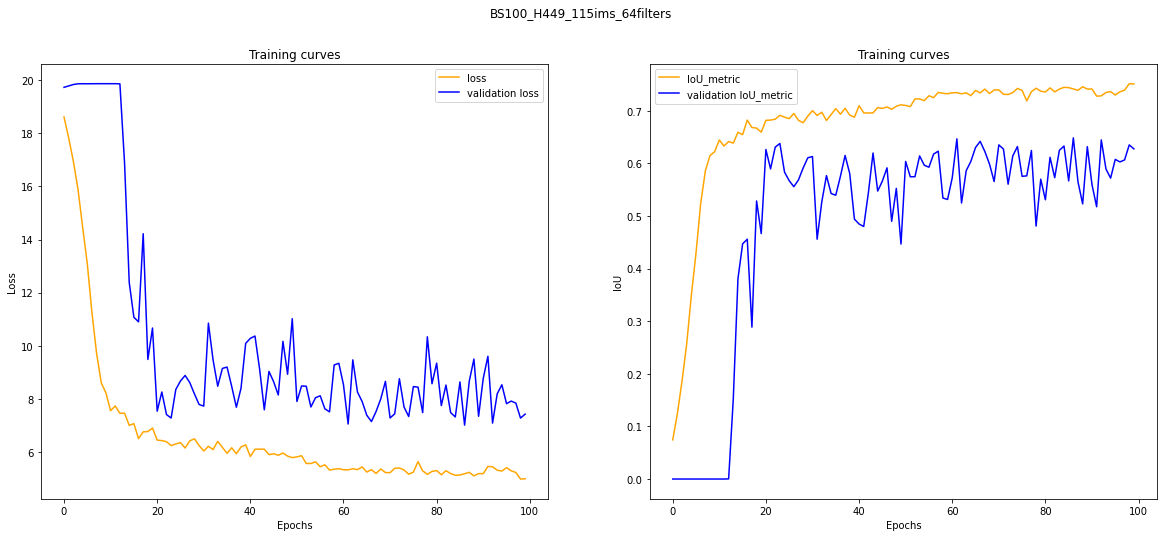

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
os.chdir("D:/Hugo/BiSeg/Models")

# model
n_epochs = 100
model_name = f"BS{n_epochs}_H449_115ims_64filters"
n_filters, init_lr, f_activ = 64, 5e-4, "sigmoid"
unet = get_unet(n_filters, 512, 512, n_channels_imgs=nc_ims, n_channels_masks=nc_masks, final_activation=f_activ)  # linear for EDM regression
# unet = keras.models.load_model("BS1000_overfit", custom_objects={"jaccard_distance_fixed": jaccard_distance})

# loss and metrics
metrics_name = "IoU_metric"
def IoU_metric(y_true, y_pred):
    threshold = tf.constant(0.5, dtype=tf.float32)
    y_pred = K.cast(tf.math.greater(y_pred, threshold), dtype="float32")
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    return K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)

smooth = 20
if smooth == 0:
    loss = "binary_cross_entropy"
else:
    loss = jaccard_distance(smooth=smooth)

print(f"Using loss : {loss}.")
print(f"Smoothing : {smooth}")

# callbacks
save_predictions = PredictOnImagesCallback(val_generator, f"predictions_on_val_image_during_training", model_name, n_images_to_predict=1)
model_checkpoint = ModelCheckpoint(f"{model_name}_checkpoint.hdf5", save_best_only=True, monitor='val_loss')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, verbose=1, patience=8, min_lr=1e-7)
callbacks = [reduce_lr, save_predictions, model_checkpoint]

# train step
unet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=init_lr),
    # loss=keras.losses.BinaryCrossentropy(),
    loss=loss,
    metrics=IoU_metric,
#     metrics=[tf.keras.metrics.MeanSquaredError()],
)
history = unet.fit(generator, validation_data=val_generator, 
                   epochs=n_epochs, verbose=1, callbacks=callbacks)

# plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history.history["loss"][:], "orange", label="loss")
ax[0].plot(history.history["val_loss"][:], "b", label="validation loss")
ax[0].legend()
ax[0].set_title("Training curves")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel(f"Loss")
# ax[0].set_ylabel("Loss (MSE)")

ax[1].plot(history.history[metrics_name][:], "orange", label=metrics_name)
ax[1].plot(history.history[f"val_{metrics_name}"][:], "b", label=f"validation {metrics_name}")
# ax[1].plot(history.history["mean_squared_error"][10:], "orange", label="MSE")
# ax[1].plot(history.history["val_mean_squared_error"][10:], "b", label="validation MSE")
ax[1].legend()
ax[1].set_title("Training curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU")

# save model
fig.suptitle(model_name)

os.chdir("D:/Hugo/BiSeg/Models")
unet.save(model_name)

plt.savefig(f"{model_name}/{model_name}_learning_curve.png")

list_training_imgs = "\n".join(os.listdir(generator.X_dir))
list_val_imgs = "\n".join(os.listdir(val_generator.X_dir))

with open(f"{model_name}/history.txt", "w") as hist_file:
    hist_file.write(f"Model {model_name} trained for {n_epochs} epochs."
                    f"\n\nFinal activation layer: {f_activ}."
                    f"\n\nNumber of training images : {len(generator)} * {generator.batch_size}, from directory {generator.X_dir}, masks from {generator.Y_dir}."
                    f"\n\nNumber of validation images : {len(val_generator)} * {val_generator.batch_size}, from directory {val_generator.X_dir}, masks from {val_generator.Y_dir}."
                    f"\n\nLoss : {loss}" #, smoothing: {smooth}."
                    f"\n\nNumber of filters : {n_filters}."
                    f"\n\nInitial learning rate: {init_lr}."
                    f"\n\nList of the training images:\n{list_training_imgs}."
                    f"\n\nList of the validation images:\n{list_val_imgs}."
                   )

## Perform inference

Now we will use the model to make predictions on the test dataset to check if it can generalize well.

In [5]:
metrics_name = "IoU_metric"
def IoU_metric(y_true, y_pred):
    threshold = tf.constant(0.5, dtype=tf.float32)
    y_pred = K.cast(tf.math.greater(y_pred, threshold), dtype="float32")
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    return K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)


unet = keras.models.load_model("D:\Hugo\BiSeg\Models/BS100_H449_115ims_64filters_checkpoint.hdf5", custom_objects={"jaccard_distance_fixed": jaccard_distance, "jaccard_distance": jaccard_distance, "IoU_metric": IoU_metric})

In [7]:
import sys
if not "D:/Hugo/Python_Scripts/Utils" in sys.path:
    sys.path.append("D:/Hugo/Python_Scripts/Utils")
import image_io as imio # custom import functions

BF_path = "D:\Hugo\Data\BF_f0001\indiv_images"
RFP_path = "D:\Hugo\Data\BF_f0001\indiv_rfp"

restrict_to = -1
target_shape = (512, 512)
n_chan_ims, n_chan_ms = 2, 1

test_set = imio.preprocess(imio.merge_channels([imio.read_from_directory(path, restrict_to=restrict_to) for path in [RFP_path, BF_path]]), normalize=True, add_axis=None, target_shape=target_shape)
print(test_set.shape)

plot = False
if plot:
    visualize_data(test_set, np.zeros((1, test_set[0].shape[0], test_set[0].shape[1], 1)), n_chan_ims)

Processing a batch of dimension: (155, 2048, 2048, 2)
(155, 512, 512, 2)


In [8]:
import time
t0 = time.time()

predictions = []
for im in test_set:
    predictions.append(unet.predict(np.expand_dims(im, axis=0)).squeeze(0))
predictions = np.array(predictions)
print(f"Predictions duration for {predictions.shape[0]} images : {round(time.time() - t0, 2)} sec.")
print(predictions.shape)

def visualize_data_and_predictions(bf, masks, nc_ims=1, nc_masks=1):
    if nc_ims == 1:
        viewer = napari.view_image(bf[:, :, :, :].squeeze(-1))
    else:
        viewer = napari.view_image(bf[:, :, :, 0])  # bf
        for k in range(1, nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    if nc_masks == 1:    
        viewer.add_image(masks[:, :, :, :].squeeze(-1), blending="additive", colormap="blue")
    else:
        for k in range(0, nc_masks):
            viewer.add_image(masks[:, :, :, k], blending="additive")

plot = True
if plot:
    visualize_data_and_predictions(test_set, predictions, nc_ims=2, nc_masks=1)

Predictions duration for 155 images : 16.88 sec.
(155, 512, 512, 1)


In [9]:
save_predictions = True
if save_predictions:
    # REPLACE TEST SAVE PREDICTIONS PATH
    save_path = ["D:/Hugo/BiSeg/Predictions/BS100-h449only-64filters_BFf0001.tif"]
#     predicted_nochan = predictions#.squeeze(-1)
    
    for k in range(nc_masks):
        imageio.volwrite(save_path[k], predictions[:, :, :, k])

## Save the model

In [ ]:
# REPLACE SAVE MODEL PATH
save_model_path = "/content/gdrive/MyDrive/CYBERSCOPE/Migration/Models"
unet.save(save_model_path)